# Random Forest
Try reading gzip files on mac and CoLab.

Previous run used abs(diff) but that masks critical information about which parent is better. Rerun without the abs() function.

In [15]:
from datetime import datetime
print(datetime.now())

2023-06-07 15:27:44.994528


In [16]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/IRP2/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/IRP2/Models/'  # must end in "/"
except:
    IN_COLAB = False
    print('Running on Mac')
    DATA_DIR="/Users/jasonmiller/WVU/BAM_ML/"
    MODEL_DIR="/Users/jasonmiller/WVU/BAM_ML/Models/"
SAVE_MODEL_FILENAME = None 

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [17]:
from platform import python_version
print('Python',python_version())
import numpy as np
np.random.seed(42) # supposedly sets scikit-learn
import pandas as pd  # for plotting
import time # sleep function
from os.path import isfile
import gzip
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier as RFC

EPOCHS=150 

Python 3.10.11
sklearn 1.2.2


## Data Load

In [18]:
MAX_LINES_TO_LOAD =    1000 # use this for debugging
MAX_LINES_TO_LOAD =    1000000 # training - 1M lines requires 2GB RAM

VALID_PORTION = 0.20

DATA_FILE_0 = 'MxM_BR4/ml_stats.csv.gz'
DATA_FILE_1 = 'SxS_BR4/ml_stats.csv.gz'

print('Data directory: %s'%DATA_DIR)
print('Data file 0 %s'%DATA_FILE_0)
print('Data file 1 %s'%DATA_FILE_1)
print('Input lines for training: %d'%MAX_LINES_TO_LOAD)

Data directory: /content/drive/My Drive/data/IRP2/
Data file 0 MxM_BR4/ml_stats.csv.gz
Data file 1 SxS_BR4/ml_stats.csv.gz
Input lines for training: 1000000


In [19]:
# P1 parent 1
# R1 read 1
# PS primary or secondary
# AS bowtie alignment score (0 is best)
# ED edit distance
# MM mismatch count
# GO gap open count
# GE gap extend count
feature_names = [
    'P1 R1 AS x',
    'P1 R1 ED x',
    'P1 R1 MM',
    'P1 R1 GO',
    'P1 R1 GE',
    'P1 R2 AS x',
    'P1 R2 ED x',
    'P1 R2 MM',
    'P1 R2 GO',
    'P1 R2 GE',
    'P2 R1 AS x',
    'P2 R1 ED x',
    'P2 R1 MM',
    'P2 R1 GO',
    'P2 R1 GE',
    'P2 R2 AS x',
    'P2 R2 ED x',
    'P2 R2 MM',
    'P2 R2 GO',
    'P2 R2 GE',
    'AS diff x',
    'ED diff x',
    'MM diff',
    'GO diff',
    'GE diff',
    'P2 Primary x',
    'P1 Span',
    'P2 Span',
    'Span diff']

In [20]:
class DataLoader():
    def __init__(self,filepath1,filepath2,verbose=True):
        self.files = [filepath1,filepath2]
        self.alignments=[]
        self.labels=[]
        self.is_primary={'P':1, 'S':0}
        self.verbose = verbose
        self.max_lines = None
        
    def set_max_lines(self,lines):
        '''Limit the dataset size to fit in RAM.'''
        self.max_lines = lines
        if self.verbose:
            print('Maximum lines to load per file: %d'%lines)
        
    def _count_lines_(self):
        '''Show number of lines per input file.'''
        count0 = 0
        with gzip.open (self.files[0],'rt') as handle0:
            for row in handle0:
                count0 += 1
        count1 = 0
        with gzip.open(self.files[1],'rt') as handle1:
            for row in handle1:
                count1 += 1
        minimum = min(count0,count1)
        if self.verbose:
            print('File0 size: %d %s'%(count0,self.files[0]))
            print('File1 size: %d %s'%(count1,self.files[1]))
        return minimum
        
    def _load_line_(self,row):
        '''Load data structure from one line of CSV file.'''
        line = row.strip()
        fields = line.split(',')
        ints = [0] * 29
        # These fields come straight from the input file.
        # These fields are grouped by which read they describe.
        # P1 R1 AS = Parent 1, Read 1, Alignment Score
        ints[0] = 0 # int(fields[1]) # P1 R1 AS
        ints[1] = 0 # int(fields[2]) # P1 R1 ED
        ints[2] = int(fields[3]) # P1 R1 MM
        ints[3] = int(fields[4]) # P1 R1 GO
        ints[4] = int(fields[5]) # P1 R1 GE
        ints[5] = 0 # int(fields[7]) # P1 R2 AS
        ints[6] = 0 # int(fields[8]) # P1 R2 ED
        ints[7] = int(fields[9]) # P1 R2 MM
        ints[8] = int(fields[10]) # P1 R2 GO
        ints[9] = int(fields[11]) # P1 R2 GE
        ints[10] = 0 # int(fields[13]) # P2 R1 AS
        ints[11] = 0 # int(fields[14]) # P2 R1 ED
        ints[12] = int(fields[15]) # P2 R1 MM
        ints[13] = int(fields[16]) # P2 R1 GO
        ints[14] = int(fields[17]) # P2 R1 GE
        ints[15] = 0 # int(fields[19]) # P2 R2 AS
        ints[16] = 0 # int(fields[20]) # P2 R2 ED
        ints[17] = int(fields[21]) # P2 R2 MM
        ints[18] = int(fields[22]) # P2 R2 GO
        ints[19] = int(fields[23]) # P2 R2 GE    
        # We compute these 'diff' fields from the input data.
        ints[20] = int(((ints[10]+ints[15])-(ints[0]+ints[5]))/2) # AS diff
        ints[21] = int(((ints[11]+ints[16])-(ints[1]+ints[6]))/2) # ED diff
        ints[22] = int(((ints[12]+ints[17])-(ints[2]+ints[7]))/2) # MM diff
        ints[23] = int(((ints[13]+ints[18])-(ints[3]+ints[8]))/2) # GO diff
        ints[24] = int(((ints[14]+ints[19])-(ints[4]+ints[9]))/2) # GE diff
        # The data file contains one letter describing parent 2 (e.g. SxS).
        # The letter is P for primary or S for secondary (derived from a BAM flag).
        # We convert so is_primary==1 means parent 2 is the primary parent.
        primary_letter = fields[12]  # parent 2 is P=primary or S=Secondary
        primary_digit = self.is_primary[primary_letter] # convert P to 1, S to 0
        ints[25] = 0 # primary_digit  # value 1 means Parent 2 is primary
        # The span of this read pair along either parent.
        ints[26] = int(fields[24]) # span on P1
        ints[27] = int(fields[25]) # span on P2
        ints[28] = ints[25]-ints[24] # Span diff
        # The transcript (in both parents) that this read pair aligned to.
        # An upstream filter removes cases of different transcript per parent.
        transcript_id = fields[26] # TO DO: where to put this?
        self.alignments.append(ints)
    
    def load_full_train_set(self):
        '''Load full train set (to be used for train and valiation).
           Use set_max_lines() to leave some data for the test set.'''
        minimum = 0
        train_size = self.max_lines
        if self.verbose:
            print('Trying to load %d lines per file...'%train_size)
        try:
            handle0 = gzip.open(self.files[0],'rt')
            handle1 = gzip.open(self.files[1],'rt')
            # Associate label 0 with data from file 0. Same for 1.
            for i in range(train_size):
                row = next(handle0)
                self._load_line_(row)
                self.labels.append(0) 
                row = next(handle1)
                self._load_line_(row)
                self.labels.append(1)
            handle0.close()
            handle1.close()
        except Exception as e:
            print(e)
            raise Exception('CANNOT LOAD DATA FROM FILE!')

    def show_examples(self,head=6):
        head = min(head,len(self.alignments))
        for i in range(head):
            print('From '+self.files[self.labels[i]])
            print('Score,Edit,Mismatch,GapOpen,GapExtend')
            print(self.alignments[i][0:5])
            print(self.alignments[i][5:10])
            print(self.alignments[i][10:15])
            print(self.alignments[i][15:20])
            print(self.alignments[i][20:26])
            
    def get_X_y(self):
        loaded = len(self.alignments)
        divider = int(loaded - loaded * VALID_PORTION)
        X_train = np.array(self.alignments[:divider])
        y_train = np.array(self.labels[:divider])
        X_valid = np.array(self.alignments[divider:])
        y_valid = np.array(self.labels[divider:])
        if self.verbose:
            print('Full train set size = '+str(len(self.alignments)))
            print('Training/Validation partition: %d/%d'%(len(y_train),len(y_valid)))
        return X_train,y_train, X_valid,y_valid

In [21]:
print(datetime.now())
filepath0 = DATA_DIR+DATA_FILE_0
filepath1 = DATA_DIR+DATA_FILE_1
loader=DataLoader(filepath0,filepath1)
loader.set_max_lines(MAX_LINES_TO_LOAD)
print('LOADING')
loader.load_full_train_set()
print(datetime.now())
loader.show_examples()

2023-06-07 15:27:46.103869
Maximum lines to load per file: 1000000
LOADING
Trying to load 1000000 lines per file...
2023-06-07 15:27:58.998477
From /content/drive/My Drive/data/IRP2/MxM_BR4/ml_stats.csv.gz
Score,Edit,Mismatch,GapOpen,GapExtend
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
From /content/drive/My Drive/data/IRP2/SxS_BR4/ml_stats.csv.gz
Score,Edit,Mismatch,GapOpen,GapExtend
[0, 0, 5, 0, 0]
[0, 0, 2, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, -3, 0, 0, 0]
From /content/drive/My Drive/data/IRP2/MxM_BR4/ml_stats.csv.gz
Score,Edit,Mismatch,GapOpen,GapExtend
[0, 0, 1, 0, 0]
[0, 0, 2, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 2, 0, 0]
[0, 0, 0, 0, 0, 0]
From /content/drive/My Drive/data/IRP2/SxS_BR4/ml_stats.csv.gz
Score,Edit,Mismatch,GapOpen,GapExtend
[0, 0, 4, 0, 0]
[0, 0, 6, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 2, 0, 0]
[0, 0, -4, 0, 0, 0]
From /content/drive/My Drive/data/IRP2/MxM_BR4/ml_stats.csv.gz
Score,Edit,Mismatch,GapOpen,GapExtend
[0, 0, 0, 0, 0]
[0

In [22]:
X_train,y_train, X_valid,y_valid = loader.get_X_y()
print('X train shape: ')
print(np.shape(X_train))
print('y train shape: ')
print(np.shape(y_train))
print('X valid shape: ')
print(np.shape(X_valid))
print('y valid shape: ')
print(np.shape(y_valid))
print('X[5]=')
print(X_train[5])
print('y[5]=')
print(y_train[5])
#loader = None

Full train set size = 2000000
Training/Validation partition: 1600000/400000
X train shape: 
(1600000, 29)
y train shape: 
(1600000,)
X valid shape: 
(400000, 29)
y valid shape: 
(400000,)
X[5]=
[  0   0   1   0   0   0   0   6   0   0   0   0   1   0   0   0   0   6
   0   0   0   0   0   0   0   0 260 260   0]
y[5]=
1


## Model

In [23]:
def build_model():
    rfc = RFC()
    return rfc

In [24]:
print(datetime.now())
rfc_model=build_model()
print(rfc_model)

2023-06-07 15:28:03.959445
RandomForestClassifier()


## Training

In [25]:
print(datetime.now())
print("FIT")
rfc_model.fit(X_train, y_train) # sample weight
print(datetime.now())

2023-06-07 15:28:03.970540
FIT
2023-06-07 15:32:37.986192


# Validation

In [26]:
print(datetime.now())        
print("PREDICT")
yhat_pairs=rfc_model.predict_proba(X_valid)  # [ prob of 0, prob of 1 ]
yhat_pred=[pair[1] for pair in yhat_pairs]
yhat_classes=rfc_model.predict(X_valid)  # 0 or 1

print('debug pred',yhat_pred[:3])
print('debug class',yhat_classes[:3])
print(datetime.now())        

2023-06-07 15:32:38.001938
PREDICT
debug pred [0.0, 0.8051309523809522, 0.49521670656721606]
debug class [0 1 0]
2023-06-07 15:33:09.183792


In [27]:
print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
cm1 = confusion_matrix(y_valid,yhat_classes)
print('Confusion matrix\n',cm1)
cm2 = confusion_matrix(y_valid,yhat_classes,normalize='all')
print('Normalized matrix\n',cm2)

accuracy = accuracy_score(y_valid, yhat_classes)*100.
precision = precision_score(y_valid, yhat_classes)*100.
recall = recall_score(y_valid, yhat_classes)*100.
f1 = f1_score(y_valid, yhat_classes)*100.
prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
auprc = auc(prc_X,prc_Y)*100.
auroc = roc_auc_score(y_valid, yhat_pred)*100.
mcc = matthews_corrcoef(y_valid, yhat_classes)

print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 


Distrib of scores: 0.5013241682925937 mean 0.3986092073318714 std
Range of scores: 0.0 to 1.0
Confusion matrix
 [[167474  32526]
 [ 31727 168273]]
Normalized matrix
 [[0.418685  0.081315 ]
 [0.0793175 0.4206825]]
Accuracy: 83.94% Precision: 83.80% Recall: 84.14%
F1: 83.97% MCC: 0.6787
AUPRC: 91.56% AUROC: 92.13%


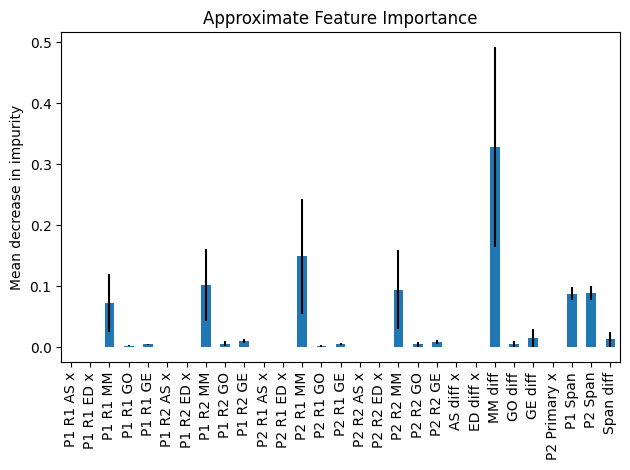

In [28]:
importances = rfc_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Approximate Feature Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# TO DO
Compute probability threshold.
Apply threshold per transcriipt.